## Data driven thermoelastic simulation

#### Background
In this note a simple example of data-driven simualtion of thermoelasticity has been presented. Both thermal and mechanical loading have been applied to a material, and afterwards, developed stressese have been calculated. In order to consider a regression problem, 14 datasets have been generated with an FEM software within the thermal range of $0^\circ$C to $1000^\circ$C. So the objective would be to train a neural network so that the stress development can be predicted at any temperature in between the mentioned range.

#### Problem description
The TiAl alloy family is an important class of materials for high temperature aerospace application, like turbine blade etc. Among a number of varieties, the duplex type is especially attractive for aero-engines. This duplex has two types of grains, i.e. lamellar and globular type. In micro and multiscale mechanics, simulations start with a representative volume element (RVE). 

#### Boundary conidtions
For generating training data, a duplex RVE has been constructed and 14 different temperatures from $0^\circ$C to $1000^\circ$C (e.g. 0, 50, 100, 200, ....1000) have been appplied one-by-one on the top surface of the RVE for 200 seconds. All other surfaces are exposed to room temperature. After 100 seconds, a constant displance rate has been applied from top surface so that the total displacement becomes 1%. The middle point of the bottom surface was fixed and the whole bottom surface was contrained ($U_z = 0$)  Assumung the thermo-elastic material model, stresses at each nodal points are computed. 

#### Input and output of NN model 
Then volumetric average of the most dominat component ($\sigma_{33}$) has been computed at each time step. So there are 200 values for each dataset. However, we do not need to use all the datapoints in a dataset. A few would be sufficient to represent the overall behavior. For example, if we take ($\sigma_{33}$) at every 10th second, i.e. 10, 20, ....200 etc., that would be representiative (Please see the curves below for training datasets). Considering the above BC's,  the input of the model would be the 14 different temperatures and the output would be the distribution of stress ($\sigma_{33}$). So one dataset means X and Y where:\
X = one fixed temperature from 0 to 1000\
Y = 20 values of ($\sigma_{33}$)

#### Training and validation set
From 14 sets of data, 11 sets have been considered for training and rest 3 sets (i.e. at temperature 250, 750, $1000^\circ$C) were considered for validation. 

#### Necessary packages and modules

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt

#### Loading datasets from local disk 

In [2]:
from google.colab import files
import io
uploaded = files.upload()

Saving ThermoElasticityDataSet20.txt to ThermoElasticityDataSet20.txt


#### Reading Datasets from the FEM simulations of thermoelasticity, Averaged $\sigma_{33}$ for 20 time steps at t=10, 20, 30, ....., 200 seconds.

In [3]:
dataset= np.loadtxt(io.BytesIO(uploaded['ThermoElasticityDataSet20.txt'])) 

X = dataset[0]
Y = dataset[1:]
Y = np.transpose(Y)

#### Separatng the training and validation sets

In [4]:

Xtest = np.array([X[4],X[10],X[13]]) # at temperature 250, 750, 1000 C
Xtrain = np.delete(X,[4,10,13])
Ytest = np.array([Y[4],Y[10],Y[13]])
Ytrain = np.delete(Y,[4,10,13],0)


#### Visualize the training dataset

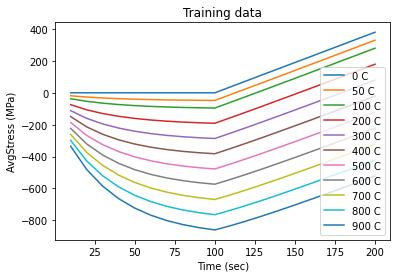

In [5]:
time=range(10,201,10)
plt.plot(time, Ytrain[0],  label='0 C')
plt.plot(time, Ytrain[1],  label='50 C')
plt.plot(time, Ytrain[2],  label='100 C')
plt.plot(time, Ytrain[3],  label='200 C')
plt.plot(time, Ytrain[4],  label='300 C')
plt.plot(time, Ytrain[5],  label='400 C')
plt.plot(time, Ytrain[6],  label='500 C')
plt.plot(time, Ytrain[7],  label='600 C')
plt.plot(time, Ytrain[8],  label='700 C')
plt.plot(time, Ytrain[9],  label='800 C')
plt.plot(time, Ytrain[10], label='900 C')
plt.xlabel('Time (sec)')
plt.ylabel('AvgStress (MPa)')
plt.title('Training data')
plt.legend()

plt.show()

#### Validation dataset

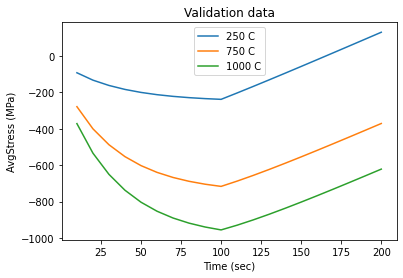

In [6]:
time=range(10,201,10)
plt.plot(time, Ytest[0],  label='250 C')
plt.plot(time, Ytest[1],  label='750 C')
plt.plot(time, Ytest[2],  label='1000 C')

plt.xlabel('Time (sec)')
plt.ylabel('AvgStress (MPa)')
plt.title('Validation data')
plt.legend()

plt.show()

One thing we can clearly observe from the above datasets that, stresses are going down from the beginning till t=100 seconds, because of no mechanical loading i.e. no applied displacement. The $\sigma_{33}$ is going up in each case after applying displacement from the top of RVE. 

#### Training sets as a list of lists

In [7]:
#Xtest
#Xtrain
#Ytest
Ytrain

array([[   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ,   37.99790628,   75.99581354,
         113.9936696 ,  151.9915444 ,  189.989415  ,  227.9873646 ,
         265.9852592 ,  303.9834358 ,  341.9809003 ,  379.9790628 ],
       [ -18.61459144,  -26.7269575 ,  -32.54861225,  -36.90721115,
         -40.19009989,  -42.6649585 ,  -44.53093913,  -45.93789575,
         -46.99877608,  -47.79868952,  -10.40391928,   27.13922512,
          64.79424621,  102.5334395 ,  140.3365126 ,  178.1874013 ,
         216.0743062 ,  253.9888552 ,  291.9235715 ,  329.8741581 ],
       [ -37.22917345,  -53.45392908,  -65.09722102,  -73.81449988,
         -80.38016291,  -85.32999552,  -89.06177843,  -91.87574855,
         -93.99761126,  -95.59730084,  -58.8056747 ,  -21.71736421,
          15.59467229,   53.07561628,   90.68353123,  128.3872355 ,
         166.1637611 ,  203.9944654 ,  241.866

#### User defined callback class for setting the stopping criteria, necessary during the time of NN training

In [9]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<0.5 and logs.get('val_loss')<1. ):
      print("\nReached MSE training<0.5 and val_loss<1, so cancelling training!")
      self.model.stop_training = True

#### Let's find the best learning rate

In [20]:
model = tf.keras.Sequential([
    keras.layers.Dense(units=1024, activation='relu', input_shape=[1]),
    keras.layers.Dense(units=2048,activation='relu'),
    keras.layers.Dense(units=512,activation='relu'),
    keras.layers.Dense(units=20)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-11 * 10**(epoch / 100))
adamOptimizer = tf.keras.optimizers.Adam(learning_rate=0.001) #lr=2e-2 was used before
model.compile(optimizer=adamOptimizer, loss='mean_squared_error')
history = model.fit(Xtrain, Ytrain, epochs=1000, callbacks=[lr_schedule] )

Epoch 1/1000
1/1 [==============================] - 0s 2ms/step - loss: 149453.4375
Epoch 2/1000
1/1 [==============================] - 0s 1ms/step - loss: 149453.4375
Epoch 3/1000
1/1 [==============================] - 0s 2ms/step - loss: 149453.4375
Epoch 4/1000
1/1 [==============================] - 0s 2ms/step - loss: 149453.4219
Epoch 5/1000
1/1 [==============================] - 0s 2ms/step - loss: 149453.4375
Epoch 6/1000
1/1 [==============================] - 0s 4ms/step - loss: 149453.4219
Epoch 7/1000
1/1 [==============================] - 0s 2ms/step - loss: 149453.4375
Epoch 8/1000
1/1 [==============================] - 0s 1ms/step - loss: 149453.4219
Epoch 9/1000
1/1 [==============================] - 0s 1ms/step - loss: 149453.4219
Epoch 10/1000
1/1 [==============================] - 0s 1ms/step - loss: 149453.4219
Epoch 11/1000
1/1 [==============================] - 0s 2ms/step - loss: 149453.4375
Epoch 12/1000
1/1 [==============================] - 0s 2ms/step - loss: 1

(1e-07, 0.1, 0.0, 150000.0)

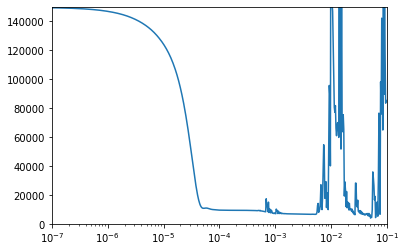

In [21]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-1, 0, 150000])

It seems the best learning rate would be nearly at $2e^{-2}$. However, convergence cannot be achieved everytime with this learning rate, so this lr is in the unstable region of lr. The best accuracy can be achieved only with this lr.

#### Let's start the training. One drawback of this NN model is that it does not converge or cannot achieve the specified accuracy everytime the model is run.  

In [43]:
callbacks = myCallback()

#Activation function use na korle model diverge kore
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1024, activation='relu', input_shape=[1]),
    tf.keras.layers.Dense(units=2048,activation='relu'),
    tf.keras.layers.Dense(units=512,activation='relu'),
    #tf.keras.layers.Dense(units=256,activation='relu'),
    #tf.keras.layers.Dense(units=128,activation='relu'),
    #tf.keras.layers.Dense(units=64,activation='relu'),
    #tf.keras.layers.Dense(units=16,activation='relu'),
    tf.keras.layers.Dense(units=20)
])

adamOptimizer=tf.keras.optimizers.Adam(lr=2e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-8) #lr=3e-3
model.compile(optimizer=adamOptimizer, loss='mean_squared_error')
model.summary()
history = model.fit(Xtrain, Ytrain, epochs=1500, callbacks=[callbacks], validation_data=(Xtest, Ytest))


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 1024)              2048      
_________________________________________________________________
dense_65 (Dense)             (None, 2048)              2099200   
_________________________________________________________________
dense_66 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_67 (Dense)             (None, 20)                10260     
Total params: 3,160,596
Trainable params: 3,160,596
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
1/1 [==============================] - 0s 279ms/step - loss: 148850.6094 - val_loss: 169052672.0000
Epoch 2/1500
1/1 [==============================] - 0s 18ms/step - loss: 81249512.0000 - val_loss: 2191354.2500
Epoch 3/1500
1/1

In [53]:
model.save('ThermoelasticityPredictionByDNN.model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ThermoelasticityPredictionByDNN.model/assets


In [54]:
# For reusing this trained model
#trainedModel=tf.keras.models.load_model('ThermoelasticityPredictionByDNN.model')

# Now trainedModel.predict() diye prediction kora jabe

#### Let's observe the training and validation losses

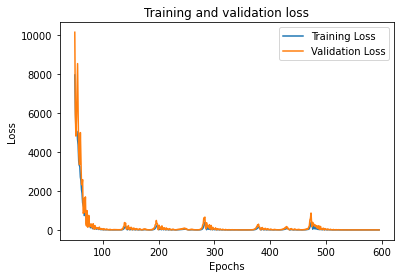

In [44]:


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs[50:], loss[50:],  label='Training Loss')
plt.plot(epochs[50:], val_loss[50:],  label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Let's compare 20 values of $\sigma_{33}$ at $1000^\circ$C, Simulation vs. DNN prediction. Maximum difference is nearly $1.75^\circ$ i.e less than 0.2%

In [45]:
print(model.predict([1000.0]))
print(Ytest[2])

[[-371.22095 -532.9351  -650.11304 -737.8458  -801.75275 -852.2983
  -889.0349  -916.9178  -938.3888  -955.0142  -929.1448  -899.84357
  -869.20306 -835.2759  -803.0701  -767.7114  -731.46094 -694.8364
  -659.1404  -621.9258 ]]
[-372.2917345 -534.5392908 -650.9722102 -738.1449988 -803.8016291
 -853.2999552 -890.6177843 -918.7574855 -939.9761126 -955.9730084
 -930.0382931 -901.1354629 -869.9975437 -837.1678529 -803.0705416
 -768.0134488 -732.2316155 -695.9037481 -659.166922  -622.1193806]


#### Now let's visualize and compare 3 predictions altogether at $250^\circ$C, $750^\circ$C and $1000^\circ$C with the original simulated results. 

Perfect prediction!

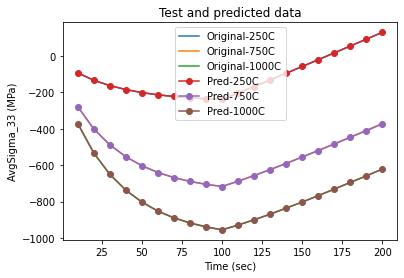

In [46]:
plt.plot(time, Ytest[0],  label='Original-250C')
plt.plot(time, Ytest[1],  label='Original-750C')
plt.plot(time, Ytest[2],  label='Original-1000C')
plt.plot(time, model.predict([250.0])[0], 'o-', label='Pred-250C')
plt.plot(time, model.predict([750.0])[0], 'o-', label='Pred-750C')
plt.plot(time, model.predict([1000.0])[0], 'o-', label='Pred-1000C')

plt.xlabel('Time (sec)')
plt.ylabel('AvgSigma_33 (MPa)')
plt.title('Test and predicted data')
plt.legend()

plt.show()

#### Training and Prediction together

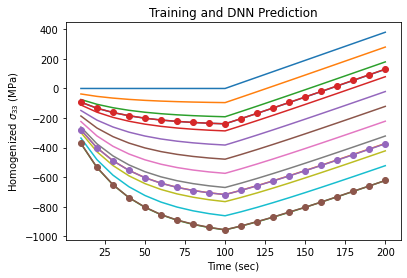

In [52]:
time=range(10,201,10)
plt.plot(time, Ytrain[0],  label='0 C')
#plt.plot(time, Ytrain[1],  label='50 C')
plt.plot(time, Ytrain[2],  label='100 C')
plt.plot(time, Ytrain[3],  label='200 C')
plt.plot(time, Ytrain[4],  label='300 C')
plt.plot(time, Ytrain[5],  label='400 C')
plt.plot(time, Ytrain[6],  label='500 C')
plt.plot(time, Ytrain[7],  label='600 C')
plt.plot(time, Ytrain[8],  label='700 C')
plt.plot(time, Ytrain[9],  label='800 C')
plt.plot(time, Ytrain[10], label='900 C')
plt.plot(time, Ytest[0],  label='Simulation_250C')
plt.plot(time, Ytest[1],  label='Simulation_750C')
plt.plot(time, Ytest[2],  label='Simulation_1000C')
plt.plot(time, model.predict([250.0])[0], 'o-', label='Pred_250C')
plt.plot(time, model.predict([750.0])[0], 'o-', label='Pred_750C')
plt.plot(time, model.predict([1000.0])[0], 'o-', label='Pred_1000C')

plt.xlabel('Time (sec)')
plt.ylabel('Homogenized $\sigma_{33}$ (MPa)')
plt.title('Training and DNN Prediction')
#plt.legend()

plt.show()

### Summary
#### DNN predictions and the original results are so close that it is difficult to differentiate. So is it clear that the NN model is able to predict the stress behavior at any temperature in between 0 to 1000 degree with the above boundary conditions (i.e. with specific dispalcement rate).  

In [1]:
#Downloading a folder from googleColab
#!zip -r /content/TrainedModel.zip /content/ThermoelasticityPredictionByDNN.model
#files.download("/content/TrainedModel.zip")